In [1]:

%pprint
import sys
sys.path.insert(1, osp.join(os.pardir, 'py'))

Pretty printing has been turned OFF


In [2]:

import os.path as osp
shared_folder = osp.abspath(osp.join(os.pardir, 'share')); assert osp.exists(shared_folder)
import sys
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)
from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join(os.pardir, 'data')),
    saves_folder_path=osp.abspath(osp.join(os.pardir, 'saves'))
)

# Import needed libraries
from scraping_utils import ScrapingUtilities
su = ScrapingUtilities()

In [3]:

url = 'https://app.ssgyms.com/'
driver = su.get_driver()
try: su.driver_get_url(driver, url_str=url)
except: driver.close()

Getting the FireFox driver
Getting URL: https://app.ssgyms.com/


In [4]:

# Change the field value to your login name
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys

input_css = '#root > div:nth-child(2) > div:nth-child(1) > div:nth-child(2) > div:nth-child(1) > div:nth-child(2) > div:nth-child(1) > input:nth-child(1)'
field_value = 'dave.babbitt@gmail.com'
input_tag = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CSS_SELECTOR, input_css))
    )
input_tag.click()
ActionChains(driver).key_down(Keys.CONTROL).send_keys('a').key_up(Keys.CONTROL).perform()
input_tag.send_keys(field_value)

In [5]:

# Click the big LOGIN button
button_css = '#root > div:nth-child(2) > div:nth-child(1) > div:nth-child(3) > div:nth-child(1) > div:nth-child(1) > span:nth-child(1)'
button_tag = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CSS_SELECTOR, button_css))
    )
button_tag.click()

In [6]:

# Change the field value to what it says in the email
input_css = '#root > div:nth-child(2) > div:nth-child(1) > div:nth-child(4) > div:nth-child(1) > div:nth-child(2) > div:nth-child(1) > input:nth-child(1)'
field_value = '6223'
input_tag = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CSS_SELECTOR, input_css))
    )
input_tag.click()
ActionChains(driver).key_down(Keys.CONTROL).send_keys('a').key_up(Keys.CONTROL).perform()
input_tag.send_keys(field_value)

In [7]:

# Click the big LOGIN button
button_css = '#root > div:nth-child(2) > div:nth-child(1) > div:nth-child(6) > div:nth-child(1) > input[type="button"]'
button_tag = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CSS_SELECTOR, button_css))
    )
button_tag.click()

In [8]:

from bs4 import BeautifulSoup as bs

page_html = driver.page_source
page_soup = bs(page_html, 'html.parser')
driver.close()

In [9]:

import re
from datetime import datetime
import pandas as pd

parent_regex = re.compile(r'TrainingItem_TrainingItem__[0-9a-zA-Z-]{5}')
date_regex = re.compile(r'TrainingItem_Date__[0-9a-zA-Z-]{5}')
notes_regex = re.compile(r'TrainingItem_Notes__[0-9a-zA-Z-]{5}')
rows_regex = re.compile(r'TrainingItem_Row__[0-9a-zA-Z-]{5}')
exercise_name_regex = re.compile(r'TrainingItem_Exercise__[0-9a-zA-Z-]{5}')
exercise_value_regex = re.compile(r'TrainingItem_ExerciseValues__[0-9a-zA-Z-]{5}')
root_soups_list = page_soup.find_all('div', attrs={'id': 'root'})
date_format = '%a, %b %d, %Y'

In [18]:

if not nu.pickle_exists('strength_training_df'):
    rows_list = []
    for root_soup in root_soups_list:
        parent_soups_list = root_soup.find_all('div', attrs={'class': parent_regex})
        for parent_soup in parent_soups_list:
            row_dict = {}
    
            # Get the date
            date_soup = parent_soup.find_all('div', attrs={'class': date_regex})[0]
            date_str = re.sub(r'\s+', ' ', date_soup.text).strip()
            date_obj = datetime.strptime(date_str, date_format).date()
            row_dict['exercise_date'] = date_obj
    
            # Get the notes
            notes_str = ''
            notes_soups_list = parent_soup.find_all('div', attrs={'class': notes_regex})
            for notes_soup in notes_soups_list:
                notes_str += '\n' + notes_soup.text
            notes_str = re.sub(r'\s+', ' ', notes_str).strip()
            row_dict['exercise_notes'] = notes_str
            
            # Add each of the training rows to the rows list
            row_soups_list = parent_soup.find_all('div', attrs={'class': rows_regex})
            for row_soup in row_soups_list:
    
                # Get the exercise name
                exercise_name = row_soup.find_all('div', attrs={'class': exercise_name_regex})[0].text
                row_dict['exercise_name'] = exercise_name
    
                # Get the excercise values
                exercise_values_list = [c.text for c in row_soup.find_all('div', attrs={'class': exercise_value_regex})[0].children]
                for i, exercise_value in enumerate(exercise_values_list): row_dict[f'exercise_value{i}'] = exercise_value
                
                rows_list.append(row_dict)
    
    # Rename some of the columns and save the dataset
    strength_training_df = pd.DataFrame(rows_list).rename(columns={
        'exercise_value0': 'set_count', 'exercise_value1': 'x', 'exercise_value2': 'rep_count', 'exercise_value3': '@', 'exercise_value4': 'rep_weight', 'exercise_value5': 'weight_unit'
    })
    for cn in ['set_count', 'rep_count', 'rep_weight']:
        strength_training_df[cn] = pd.to_numeric(strength_training_df[cn])
    nu.store_objects(strength_training_df=strength_training_df)

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\notebooks\saves\pkl\strength_training_df.pkl


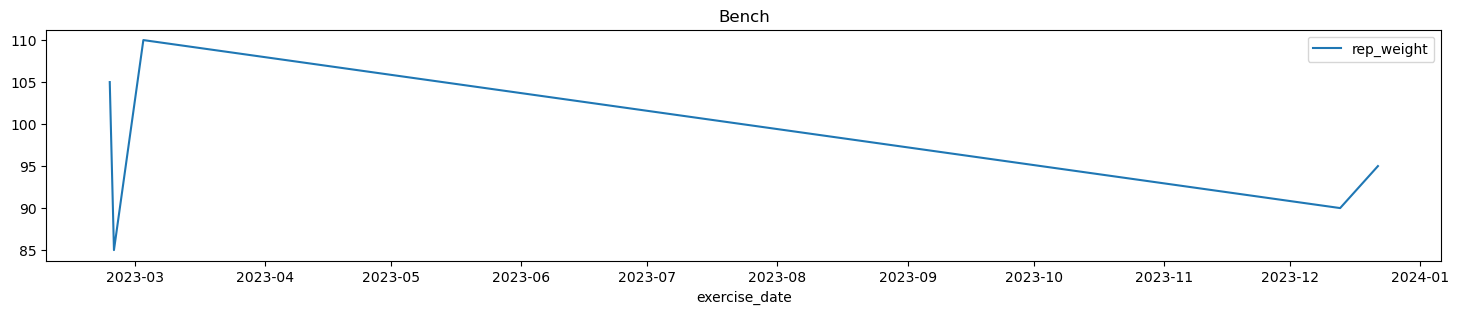

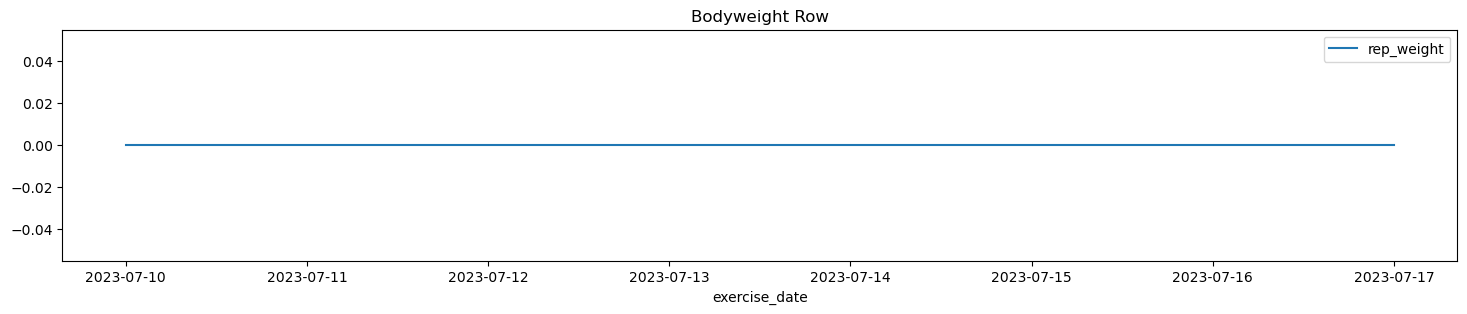

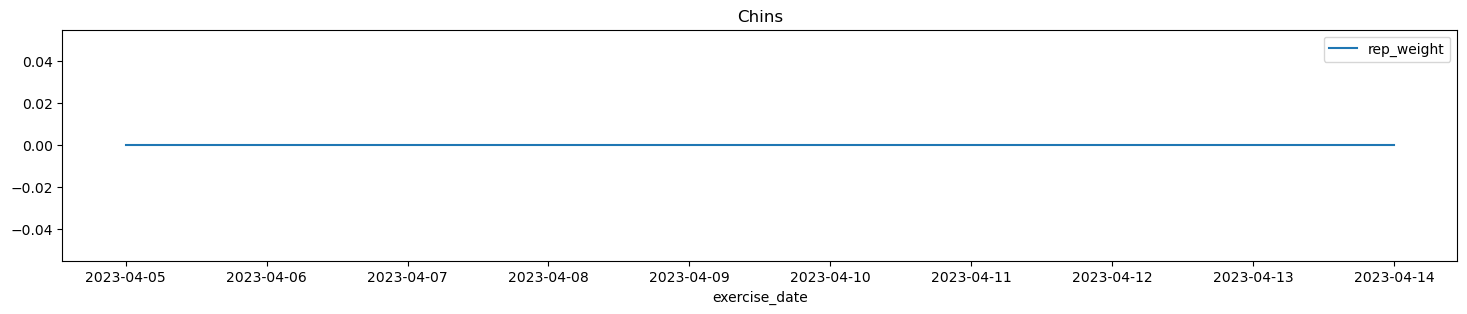

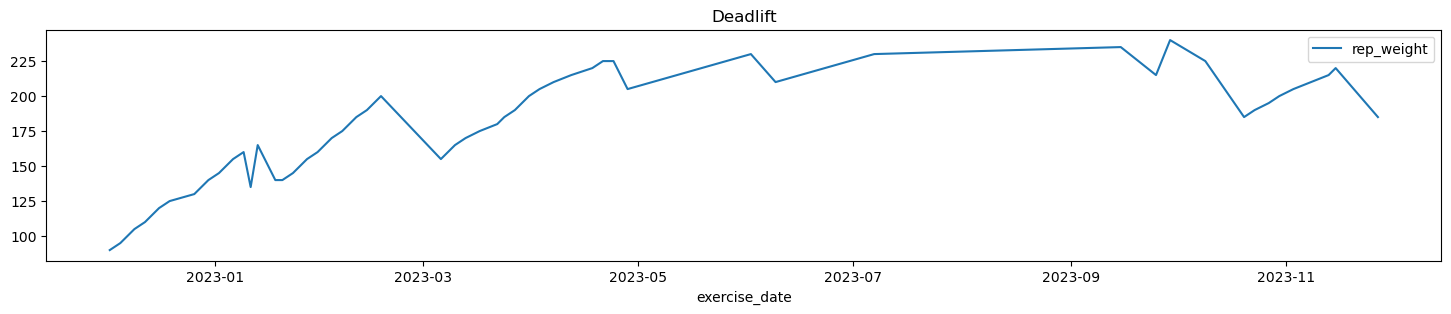

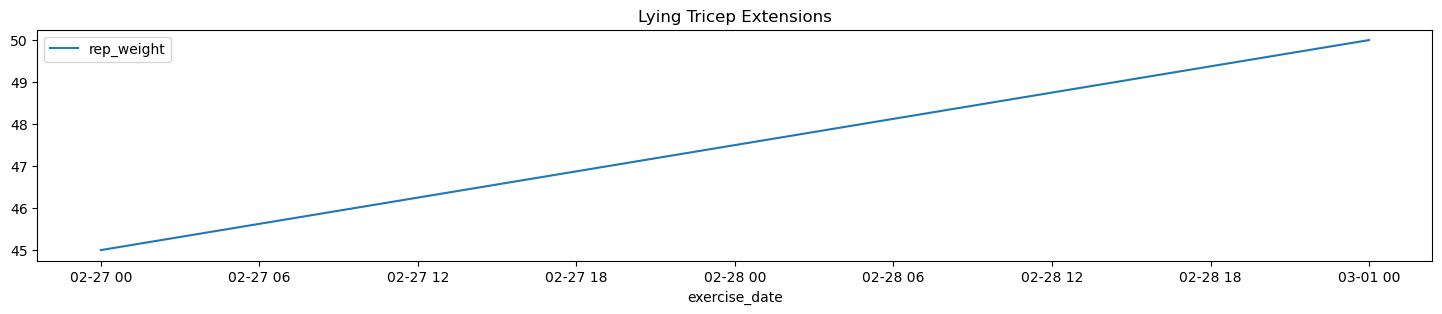

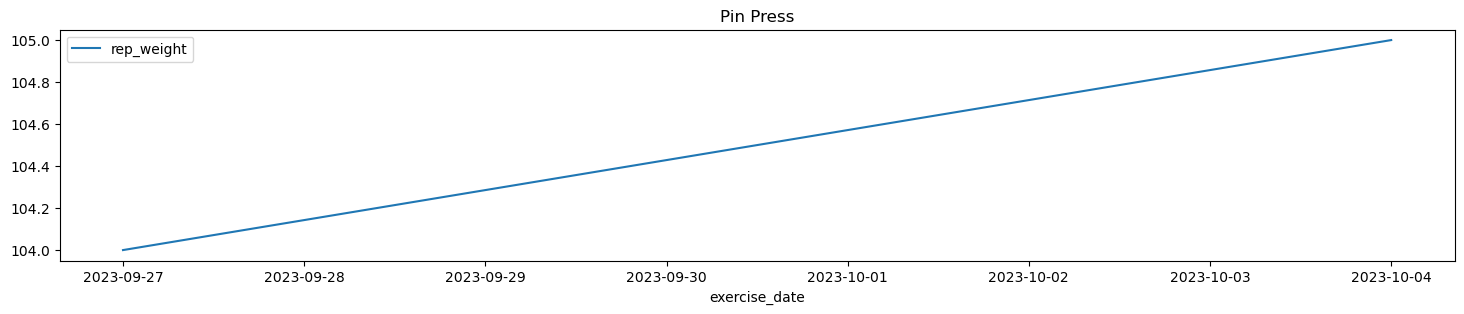

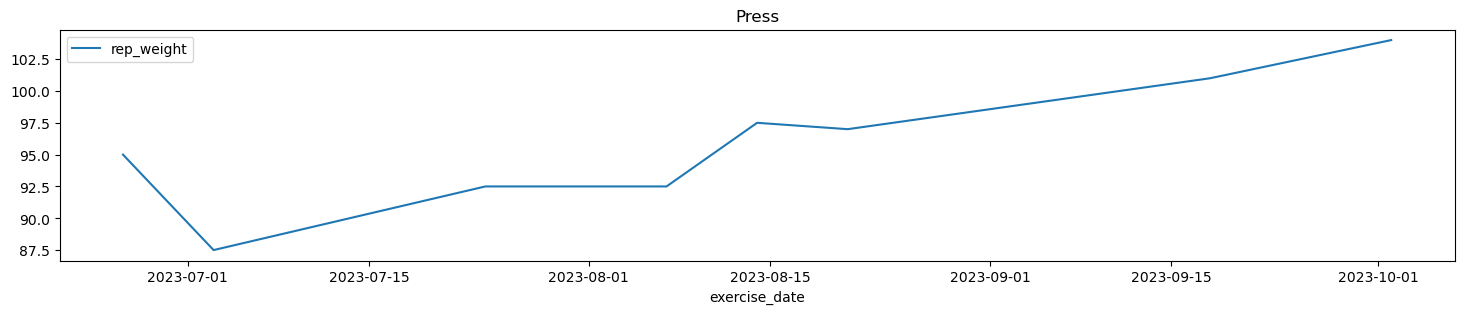

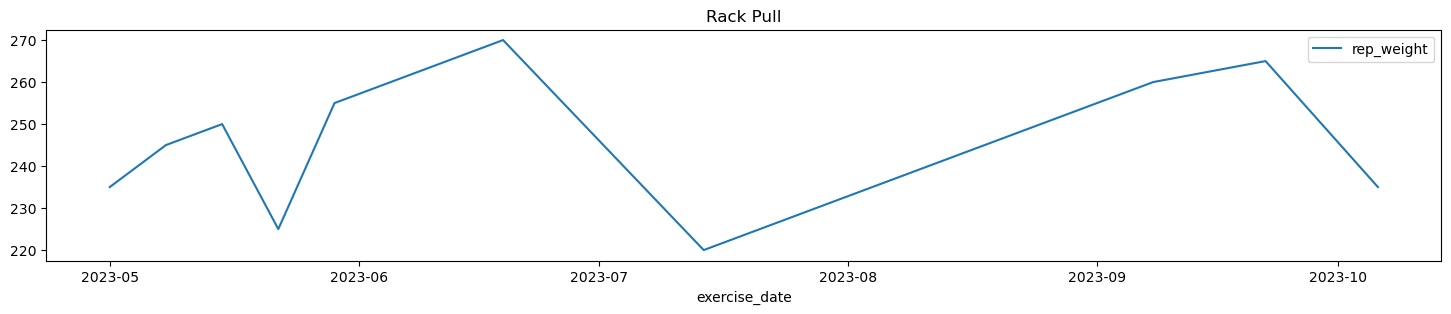

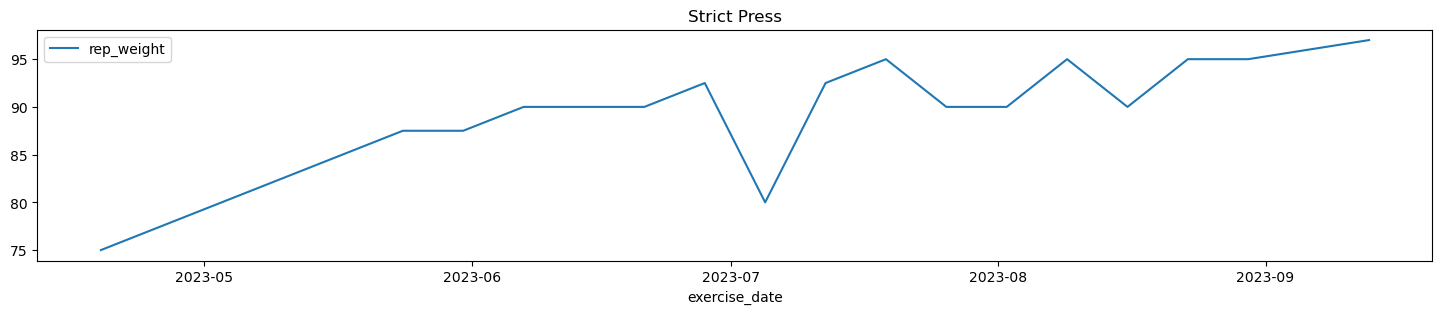

In [22]:

import matplotlib.pyplot as plt

for exercise_name, exercise_name_df in strength_training_df.sort_values('exercise_date').groupby('exercise_name'):
    fig, ax = plt.subplots(figsize=(18, 3))
    ax.set_title(exercise_name)
    exercise_name_df.plot('exercise_date', 'rep_weight', ax=ax)

In [16]:

column_descriptions_df = nu.get_column_descriptions(exercise_name_df)
column_descriptions_df

,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
0,exercise_date,object,0,5,0,True,2023-02-23,2023-12-22,NaN
1,exercise_notes,object,0,3,0,False,,Teabagging: 14” was the lowest I could get,NaN
2,exercise_name,object,0,1,0,False,Bench,Bench,NaN
3,set_count,object,0,2,0,False,3,5,True
4,x,object,0,1,0,False,x,x,NaN
5,rep_count,object,0,1,0,False,5,5,True
6,@,object,0,1,0,False,@,@,NaN
7,rep_weight,object,0,5,0,False,105,95,True
8,weight_unit,object,0,1,0,False,lbs,lbs,NaN


In [18]:

nu.open_path_in_notepad(r'~\OneDrive\Documents\GitHub\notebooks\data_analysis\../py\scraping_utils.py')

Attempting to open C:\Users\daveb\OneDrive\Documents\GitHub\notebooks\py\scraping_utils.py
